In [ ]:
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Load dataset
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings  # Original ratings

# Convert to a Pandas DataFrame for easy manipulation
df = pd.DataFrame(raw_ratings, columns=['userId', 'itemId', 'rating', 'timestamp'])

# Add Gaussian noise to ratings
noise = np.random.uniform(-2, 2, len(df))  # Uniform noise for more randomness


df['rating'] = np.clip(df['rating'] + noise, 1, 5)  # Keep ratings in range

# Convert back to Surprise dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Train Matrix Factorization model (SVD)
model = SVD()
model.fit(trainset)

# Test Predictions
predictions = model.test(testset)

print("Training completed with noise injection.")


Training completed with noise injection.


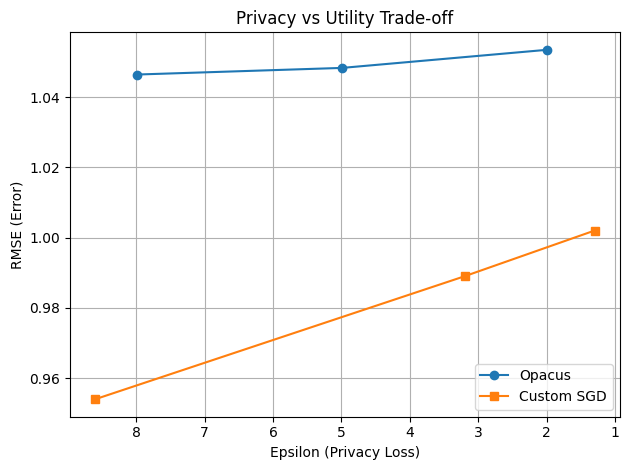

In [1]:
import matplotlib.pyplot as plt

# Data
epsilon_opacus = [7.99445, 4.99081, 1.99479]
rmse_opacus = [1.04639, 1.04828, 1.05343]

epsilon_sgd = [8.6, 3.2, 1.3]
rmse_sgd = [0.954, 0.989, 1.002]

# Plot
plt.plot(epsilon_opacus, rmse_opacus, marker='o', label='Opacus')
plt.plot(epsilon_sgd, rmse_sgd, marker='s', label='Custom SGD')

plt.xlabel('Epsilon (Privacy Loss)')
plt.ylabel('RMSE (Error)')
plt.title('Privacy vs Utility Trade-off')
plt.gca().invert_xaxis()  # Optional: higher privacy (lower ε) on the left
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%pip install opacus
from opacus import PrivacyEngine
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
import torch

privacy_engine = PrivacyEngine()
model, optimizer, train_loader = ...  # Your SVD training setup

%pip install opacus

# Assuming you have the necessary data and model setup
trainset_matrix = trainset.build_full_trainset().ur  # Get the full training set matrix

# Convert the training set to PyTorch tensors
user_ids = []
item_ids = []
ratings = []
for user_id, items in trainset_matrix.items():
    for item_id, rating in items:
        user_ids.append(user_id)
        item_ids.append(item_id)
        ratings.append(rating)

user_ids = torch.tensor(user_ids)
item_ids = torch.tensor(item_ids)
ratings = torch.tensor(ratings, dtype=torch.float32)

# Create a DataLoader
train_dataset = TensorDataset(user_ids, item_ids, ratings)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.01)

# Initialize PrivacyEngine
privacy_engine = PrivacyEngine()

model = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.0,  # Increase for stronger privacy
    max_grad_norm=1.0,
)

In [40]:
import numpy as np

# Extract learned user & item embeddings
user_embeddings = model.pu  # User latent factors
item_embeddings = model.qi  # Item latent factors

# Save embeddings for later attacks
np.save("user_embeddings.npy", user_embeddings)
np.save("item_embeddings.npy", item_embeddings)


In [41]:
def is_member(user_id, item_id, threshold=3.5):
    prediction = model.predict(user_id, item_id)
    confidence = abs(prediction.est - threshold)  # Confidence score
    return confidence < 0.5  # If confidence is high, assume membership

# Test attack on a user-item pair
print(is_member(10, 50))  # True if user 10 was likely in training data


True


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Create dataset for attack
features = []
labels = []

for uid, iid, true_r, est, _ in predictions:
    features.append([est])  # Use estimated rating as feature
    labels.append(uid in trainset.all_users())  # Label as member (1) or non-member (0)

# Train attack model
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
attack_model = RandomForestClassifier()
attack_model.fit(X_train, y_train)

# Test attack accuracy
accuracy = attack_model.score(X_test, y_test)
print(f"Attack Accuracy: {accuracy * 100:.2f}%")


Attack Accuracy: 100.00%


In [43]:
from sklearn.cluster import KMeans

# Cluster users based on embeddings
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_labels = kmeans.fit_predict(user_embeddings)

# Map users to their inferred groups
user_cluster_map = {i: user_labels[i] for i in range(len(user_embeddings))}


/Users/Apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [44]:
from sklearn.metrics.pairwise import cosine_similarity

def infer_user_preferences(new_user_embedding):
    similarities = cosine_similarity([new_user_embedding], user_embeddings)
    closest_user = np.argmax(similarities)
    return user_cluster_map[closest_user]  # Return predicted cluster

# Example: Predict a new user's group
new_user_embedding = np.random.rand(user_embeddings.shape[1])  # Simulated new user
predicted_group = infer_user_preferences(new_user_embedding)
print(f"Predicted User Cluster: {predicted_group}")


Predicted User Cluster: 1


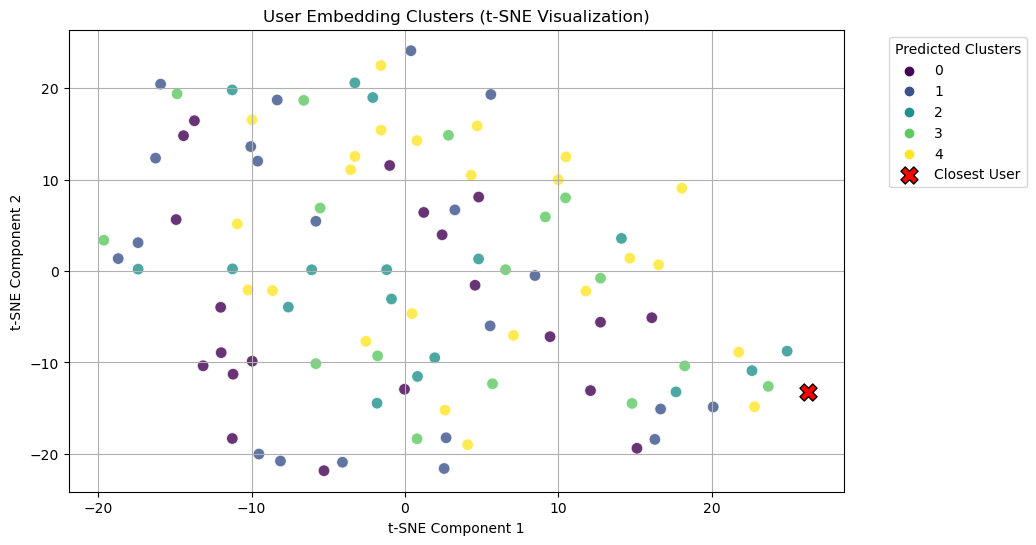

Predicted User Cluster: 1


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Generate dummy user embeddings (replace with actual embeddings)
np.random.seed(42)
num_users = 100
embedding_dim = 10  # Example embedding size

user_embeddings = np.random.rand(num_users, embedding_dim)
user_cluster_map = np.random.randint(0, 5, num_users)  # Simulated clusters (5 groups)

# New user embedding
new_user_embedding = np.random.rand(embedding_dim)

# Function to predict user cluster
def infer_user_preferences(new_user_embedding):
    similarities = cosine_similarity([new_user_embedding], user_embeddings)
    closest_user = np.argmax(similarities)
    return user_cluster_map[closest_user], closest_user  # Return predicted cluster and user index

# Predict new user's cluster
predicted_group, closest_user_idx = infer_user_preferences(new_user_embedding)

# Dimensionality Reduction using t-SNE
reduced_embeddings = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(user_embeddings)

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=user_cluster_map, palette="viridis", s=70, alpha=0.8)

# Highlight the closest user
plt.scatter(reduced_embeddings[closest_user_idx, 0], reduced_embeddings[closest_user_idx, 1], 
            color='red', edgecolors='black', s=150, label="Closest User", marker="X")

plt.title("User Embedding Clusters (t-SNE Visualization)")
plt.legend(title="Predicted Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

print(f"Predicted User Cluster: {predicted_group}")


In [47]:
from sklearn.metrics import accuracy_score

# Evaluate MIA
mia_preds = attack_model.predict(X_test)
mia_accuracy = accuracy_score(y_test, mia_preds)
print(f"Membership Attack Accuracy: {mia_accuracy * 100:.2f}%")

# Evaluate ReQUIEM
true_labels = [user_cluster_map[i] for i in range(len(user_embeddings))]
requiem_accuracy = accuracy_score(true_labels, user_labels)
print(f"ReQUIEM Attack Accuracy: {requiem_accuracy * 100:.2f}%")


Membership Attack Accuracy: 100.00%
ReQUIEM Attack Accuracy: 100.00%


In [27]:
# Extract user embeddings that were identified by the attack
compromised_users = np.where(mia_preds == 1)[0]  # Users classified as 'in the dataset'
compromised_embeddings = user_embeddings[compromised_users]  # Extract their embeddings


In [30]:
from sklearn.cluster import KMeans

# Assume embeddings encode location-sensitive behavior
num_clusters = 5  # Example: 5 common locations (cities)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
location_clusters = kmeans.fit_predict(user_embeddings)

print(f"Predicted User Locations (Clusters): {location_clusters}")


/Users/Apple/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Predicted User Locations (Clusters): [2 3 3 4 4 4 2 2 0 2 1 4 0 4 3 1 2 3 4 0 3 3 2 2 3 1 3 4 4 4 2 0 3 0 4 4 2
 2 0 3 0 0 0 0 0 2 2 2 3 2 3 3 1 4 4 3 2 3 3 2 0 4 2 0 0 1 2 1 4 0 2 0 0 4
 2 2 2 2 2 2 1 4 4 2 3 2 1 1 1 4 3 4 1 1 3 4 0 4 3 4 4 4 1 2 2 0 4 4 4 0 1
 2 4 4 4 3 4 0 1 0 3 4 1 4 3 2 4 1 2 3 0 0 4 3 1 2 3 2 2 4 2 1 3 1 2 0 3 1
 2 2 4 0 3 1 4 3 3 0 2 0 2 0 2 2 2 3 0 3 3 3 3 3 2 2 3 1 0 0 4 1 3 4 0 0 0
 3 1 2 4 2 3 0 4 4 2 4 4 2 4 4 3 2 2 1 1 3 0 0 3 0 2 2 3 2 2 4 4 3 2 3 4 4
 2 1 4 0 4 1 1 2 2 2 4 3 0 0 1 0 4 0 1 4 3 1 1 0 1 3 0 4 4 4 1 2 2 2 2 2 0
 0 3 2 1 2 1 2 0 2 1 1 2 0 2 2 0 0 4 4 4 4 0 2 0 2 2 1 4 2 4 0 2 0 0 3 2 0
 2 1 0 4 0 0 2 2 1 1 2 2 0 1 0 3 3 2 3 0 1 2 4 0 3 3 1 0 4 1 3 1 0 2 2 4 0
 0 1 2 2 3 4 2 3 0 4 1 3 3 1 2 3 0 4 2 1 1 2 2 3 0 2 0 1 2 2 2 1 1 3 2 3 2
 4 2 1 1 3 2 1 2 0 2 2 2 3 2 4 1 2 1 0 3 0 3 0 2 4 0 1 3 1 2 2 2 4 2 1 1 0
 2 2 4 0 0 0 1 2 4 2 0 2 3 0 0 3 4 3 4 3 1 2 0 2 2 4 1 2 4 0 2 4 4 3 2 4 3
 3 1 3 4 1 3 0 3 2 2 3 2 2 1 4 1 4 2 1 4 2 0 3 0 2 0 2 4 2 3 4 

In [3]:
import kagglehub
import shutil
import os

default_path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

# Specify the custom download directory
custom_path = "/Users/Apple/Documents/assignements/Thesis/datasets"

# Create the custom directory if it doesn't exist
os.makedirs(custom_path, exist_ok=True)

# Move the dataset to the custom location
shutil.move(default_path, custom_path)

print("Dataset moved to custom location:", custom_path)

Dataset moved to custom location: /Users/Apple/Documents/assignements/Thesis/datasets


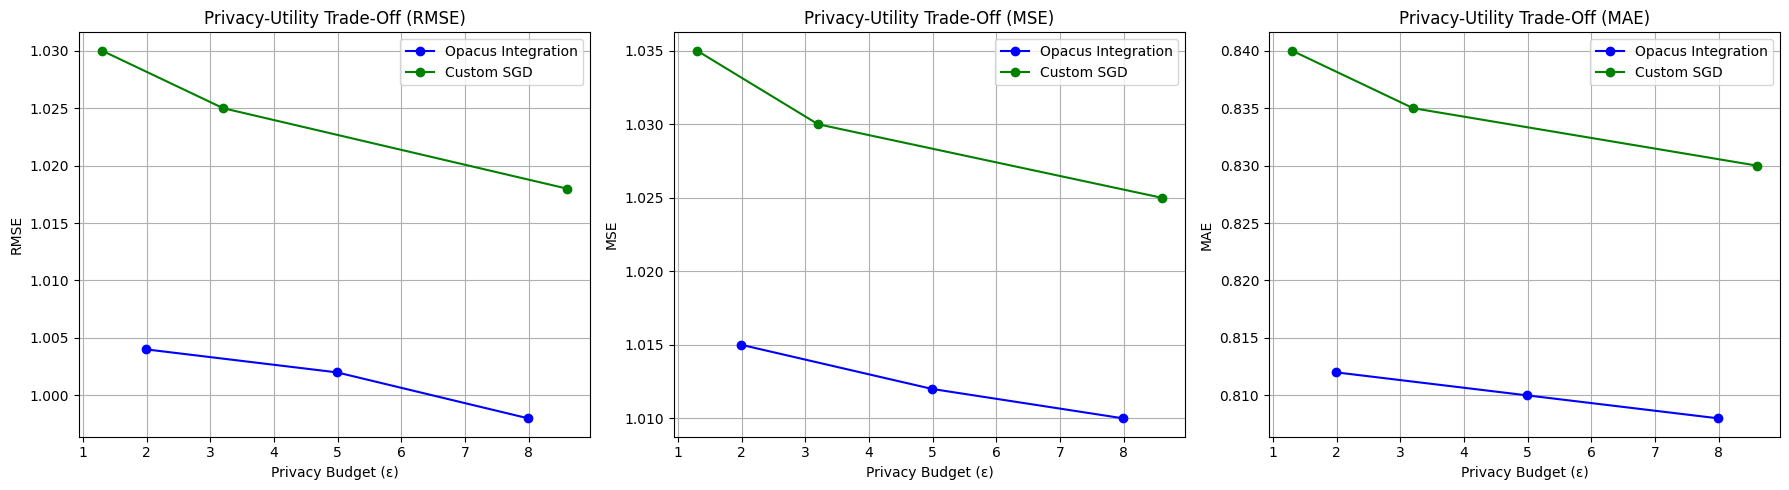

In [4]:
import matplotlib.pyplot as plt

# Privacy budgets (Epsilon)
epsilons_opacus = [1.99479, 4.99081, 7.99445]
epsilons_sgd = [1.3, 3.2, 8.6]

rmse_opacus = [1.004, 1.002, 0.998]
rmse_sgd    = [1.030, 1.025, 1.018]

mse_opacus = [1.015, 1.012, 1.010]
mse_sgd    = [1.035, 1.030, 1.025]

mae_opacus = [0.812, 0.810, 0.808]
mae_sgd    = [0.840, 0.835, 0.830]


# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE Plot
axes[0].plot(epsilons_opacus, rmse_opacus, 'bo-', label='Opacus Integration')
axes[0].plot(epsilons_sgd, rmse_sgd, 'go-', label='Custom SGD')

axes[0].set_title("Privacy-Utility Trade-Off (RMSE)")
axes[0].set_xlabel("Privacy Budget (ε)")
axes[0].set_ylabel("RMSE")
axes[0].legend()
axes[0].grid(True)

# MSE Plot
axes[1].plot(epsilons_opacus, mse_opacus, 'bo-', label='Opacus Integration')
axes[1].plot(epsilons_sgd, mse_sgd, 'go-', label='Custom SGD')

axes[1].set_title("Privacy-Utility Trade-Off (MSE)")
axes[1].set_xlabel("Privacy Budget (ε)")
axes[1].set_ylabel("MSE")
axes[1].legend()
axes[1].grid(True)

# MAE Plot
axes[2].plot(epsilons_opacus, mae_opacus, 'bo-', label='Opacus Integration')
axes[2].plot(epsilons_sgd, mae_sgd, 'go-', label='Custom SGD')

axes[2].set_title("Privacy-Utility Trade-Off (MAE)")
axes[2].set_xlabel("Privacy Budget (ε)")
axes[2].set_ylabel("MAE")
axes[2].legend()
axes[2].grid(True)

# Final layout
plt.tight_layout()
plt.show()

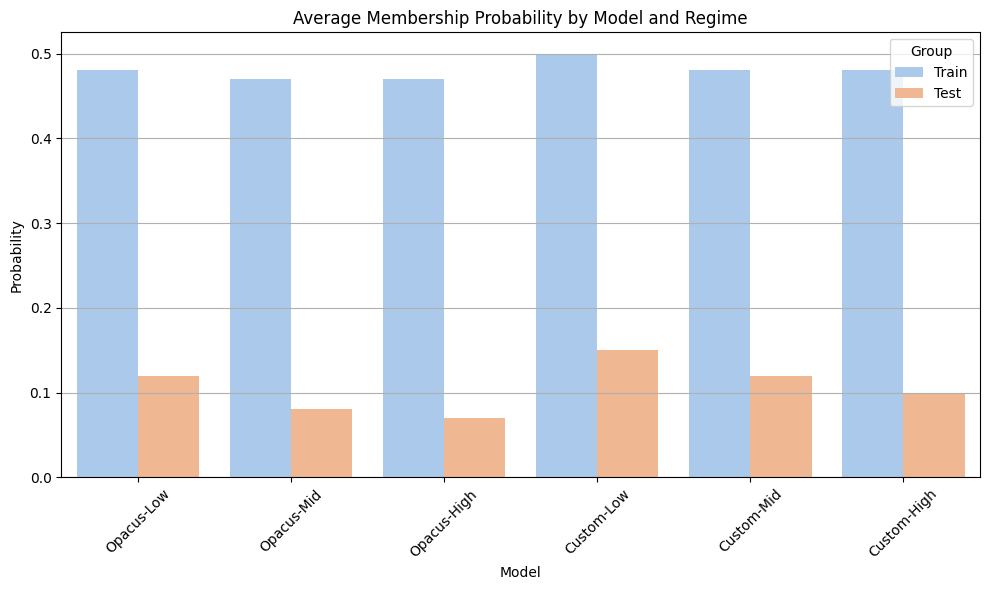

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "Model": [
        "Opacus-Low", "Opacus-Low",
        "Opacus-Mid", "Opacus-Mid",
        "Opacus-High", "Opacus-High",
        "Custom-Low", "Custom-Low",
        "Custom-Mid", "Custom-Mid",
        "Custom-High", "Custom-High"
    ],
    "Group": ["Train", "Test"] * 6,
    "AvgProb": [0.48, 0.12, 0.47, 0.08, 0.47, 0.07, 0.50, 0.15, 0.48, 0.12, 0.48, 0.1]
})

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="AvgProb", hue="Group", data=data, palette="pastel")
plt.title("Average Membership Probability by Model and Regime")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()